In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import anndata as ad
import numpy as np
import matplotlib as mpl
import seaborn as sns
from cellcharter.gr._group import _proportion
from sklearn.preprocessing import StandardScaler
import cellcharter as cc
import squidpy as sq
from matplotlib import colors
from matplotlib import cm
from squidpy.pl._color_utils import _maybe_set_colors

/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
Global seed set to 0
/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/s

In [2]:
PALETTE_STEP = {
    'Dimensionality reduction': "#21409A",
    'Spatial embedding': "#006838",
    'Clustering': "#C2B59B"
}

In [3]:
times_cpu = pd.read_csv('results/imc_human_lung_cancer/time_imc_human_lung_cancer_CellCharter_k26_cpu.csv', index_col=0)
times_gpu = pd.read_csv('results/imc_human_lung_cancer/time_imc_human_lung_cancer_CellCharter_k26_gpu.csv', index_col=0)

In [4]:
times_cpu.index = ['CellCharter (CPU)']
times_gpu.index = ['CellCharter (GPU)']
times = pd.concat([times_cpu, times_gpu], axis=0)
times /= 60

(0.0, 83.0)

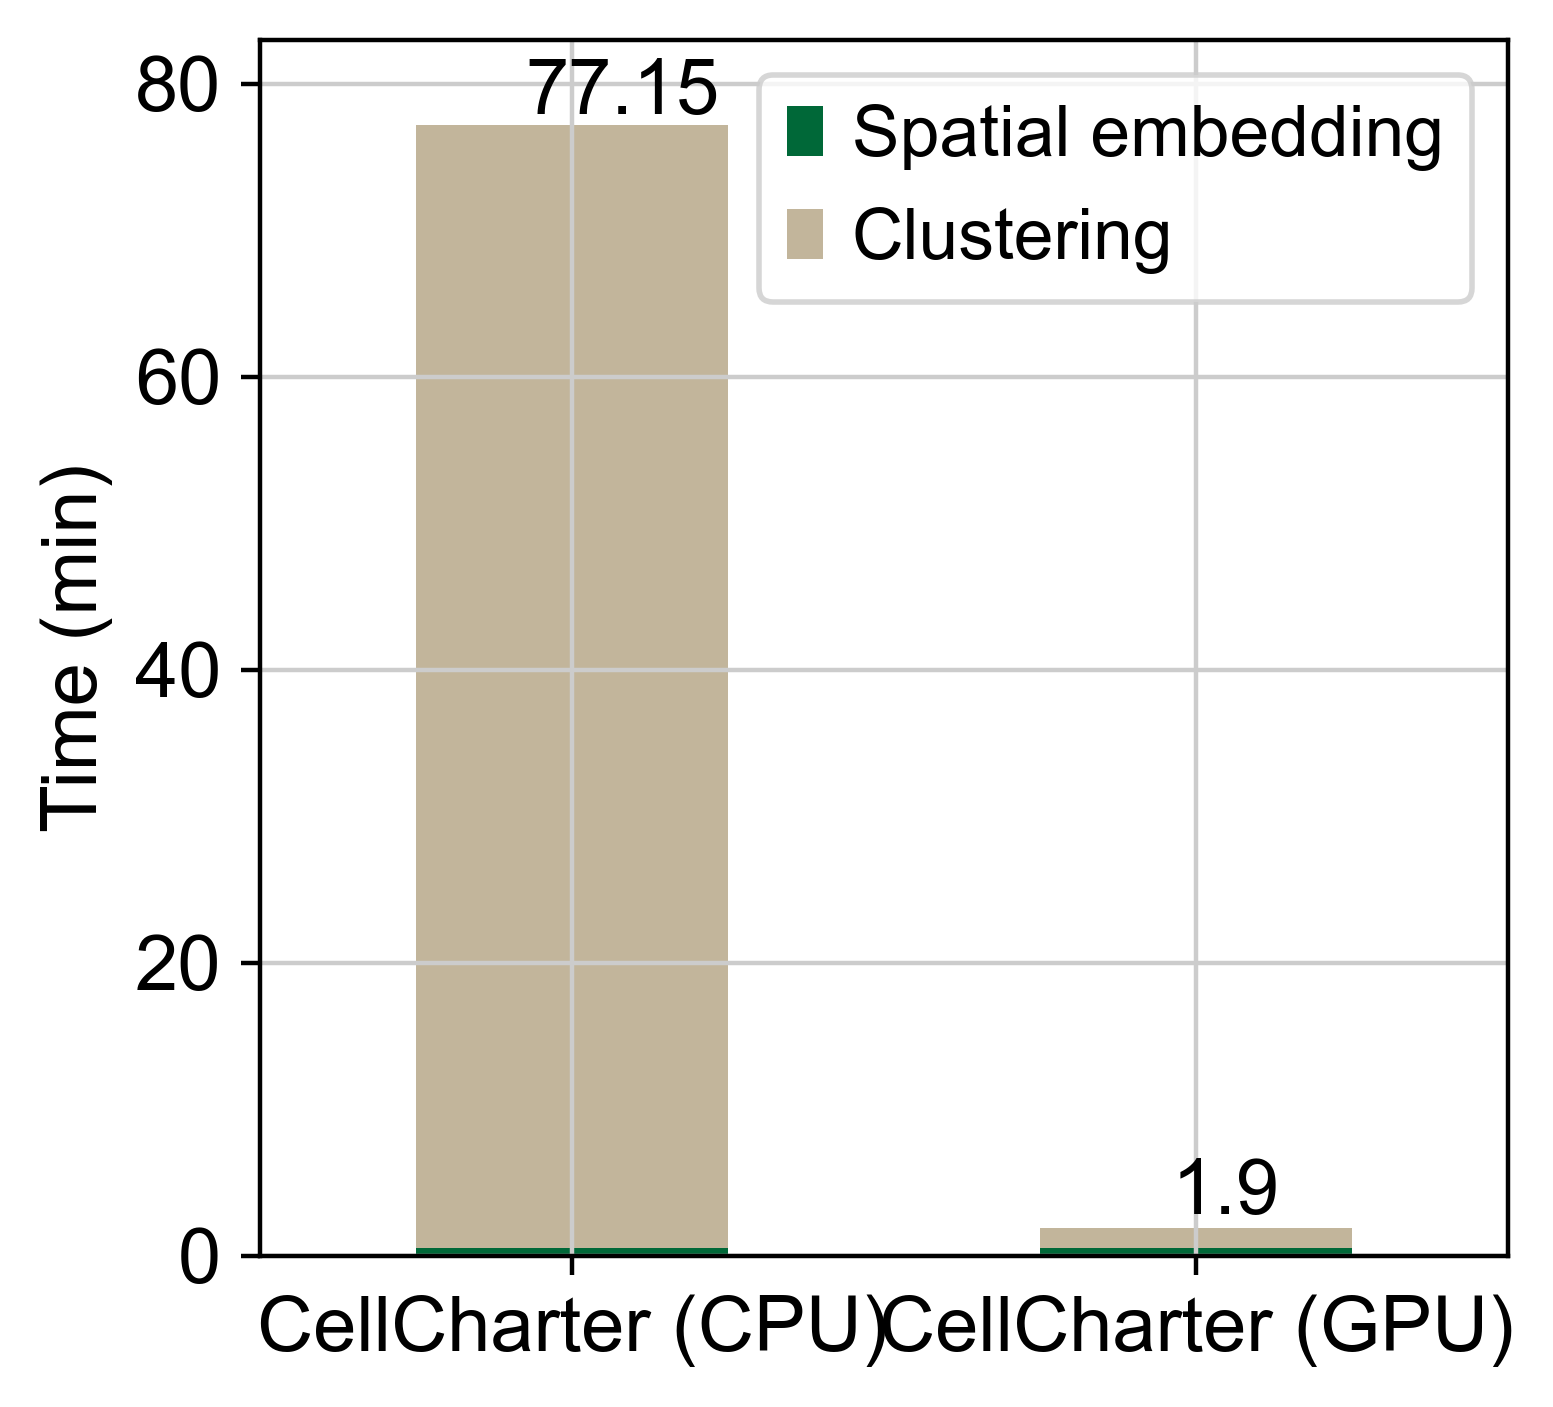

In [5]:
ax = times.loc[['CellCharter (CPU)', 'CellCharter (GPU)'], ['Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)

height_sum = [0, 0]
for p in ax.patches:
    height_sum[int(p.get_x() == -0.25)] += p.get_height()
ax.annotate(str(round(height_sum[0], 2)), (0.75 * 1.28, height_sum[0] * 1.5))
ax.annotate(str(round(height_sum[1], 2)), (-0.25 * 0.30, height_sum[1] * 1.01))
plt.ylim(0, 83)

In [6]:
adata = ad.read_h5ad('data/imc_human_lung_cancer/imc_human_lung_cancer.h5ad')

In [7]:
_maybe_set_colors(source=adata, target=adata, key='cluster_cellcharter')
colormap = adata.uns['cluster_cellcharter_colors']
categories = adata.obs['cluster_cellcharter'].cat.categories
colormap[categories.get_loc(7)], colormap[categories.get_loc(5)], colormap[categories.get_loc(23)], colormap[categories.get_loc(13)], colormap[categories.get_loc(26)] = colors.to_hex(cm.get_cmap('tab20')(5)), colors.to_hex(cm.get_cmap('tab20')(10)), colormap[categories.get_loc(26)], colormap[categories.get_loc(7)], colormap[categories.get_loc(23)]

In [8]:
TUMOR_CLUSTERS = [0, 5, 13, 23, 29]
NORMAL_CLUSTERS = [10, 7, 26, 1, 18, 4, 22, 12]

In [9]:
cc.gr.nhood_enrichment(
    adata,
    cluster_key='cluster_cellcharter'
)

/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/varrone/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


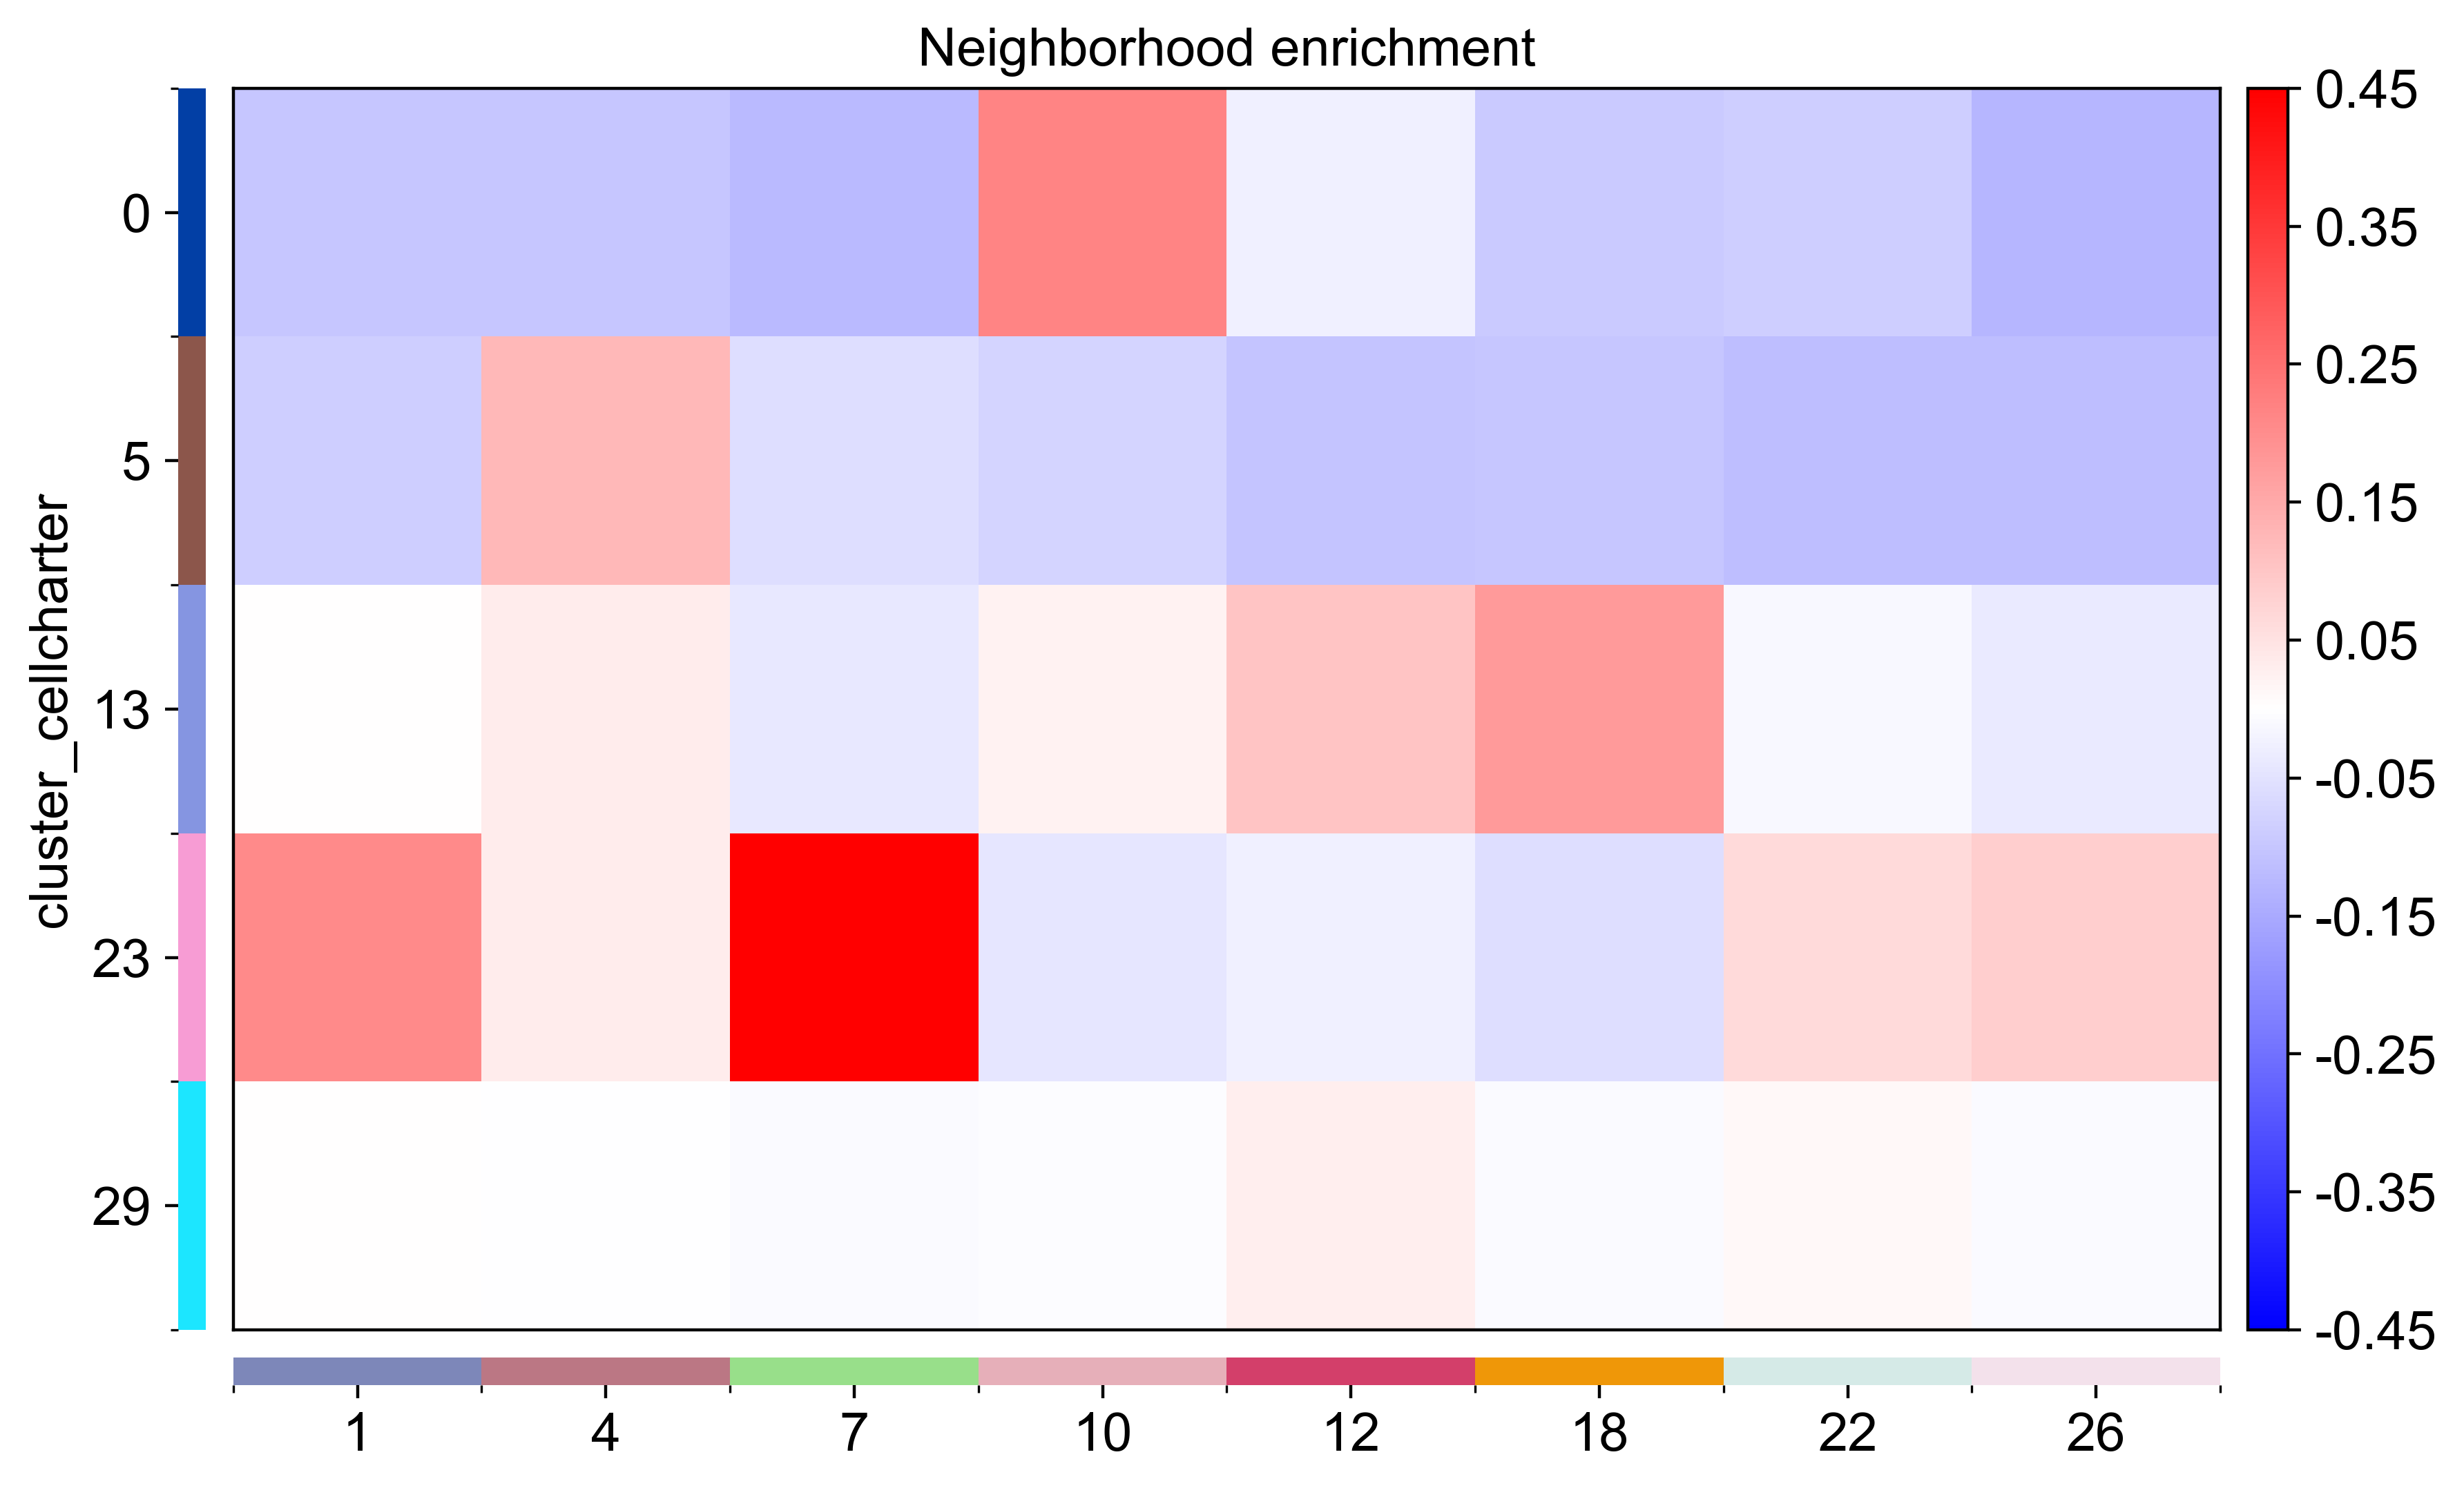

In [10]:
cc.pl.nhood_enrichment(
    adata, 
    cluster_key=f'cluster_cellcharter', 
    row_groups=TUMOR_CLUSTERS, 
    col_groups=NORMAL_CLUSTERS,
    transpose=True,
    palette=adata.uns['cluster_cellcharter_colors'],
    vmin=-0.45,
    vmax=0.45,
)
plt.show()

In [11]:
adata_cancer = adata[(adata.obs['ClusterName'] == 'Cancer') & (adata.obs['cluster_cellcharter'].isin(TUMOR_CLUSTERS))]

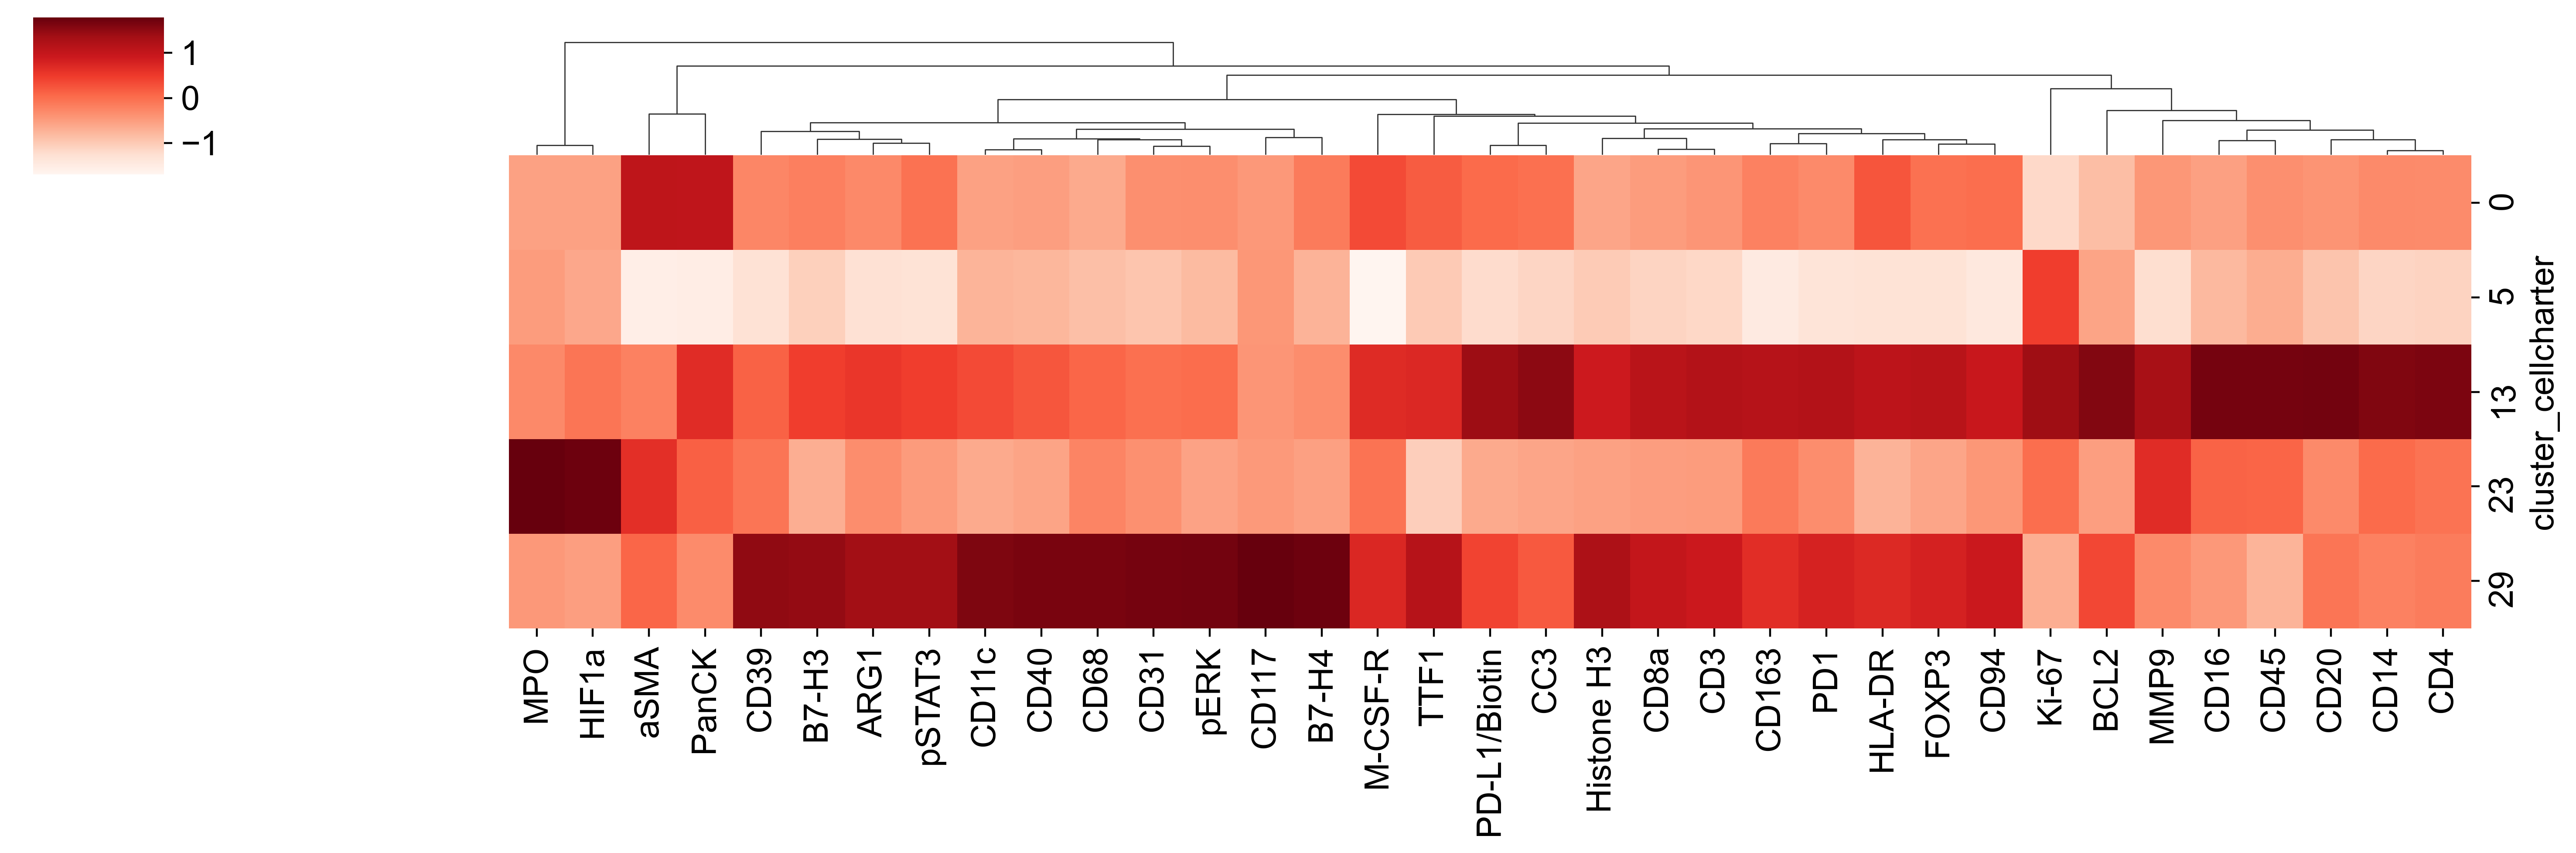

In [12]:
sns.clustermap(
    pd.concat((adata_cancer.to_df(), adata_cancer.obs), axis=1).groupby('cluster_cellcharter')[adata_cancer.var_names].mean(), 
    z_score=1, 
    figsize=(15,5), 
    cmap='Reds',
    row_cluster=False
)
plt.show()

In [13]:
proportions = _proportion(adata, 'FileName', 'cluster_cellcharter')

In [14]:
proportions_scaled = pd.DataFrame(StandardScaler().fit_transform(proportions), columns=proportions.columns, index=proportions.index)

In [15]:
sample_names = proportions_scaled[(proportions_scaled[23]> 0) & (proportions_scaled[7] > 0)].index[[17, 21, 22, 26, 41, 49]]

In [16]:
sample_names = ['Pano 01_Row2_1_ROI 04_H03-4315 E7-2_4',
             'Pano 01_Row2_1_ROI 10_H06-4287 I5-1_10',
             'Pano 01_Row3-4_1_ROI 11_H06-3610 F6-1_11',
             'Pano 01_Row6-5_1_ROI 11_H10-1374 F9-2_11',
             'Pano 01_Row8-6_1_ROI 18_H12-4349 G3-1_18',
             'Pano 01_Row8_1_ROI 02_H04-3248 H3-1_2']

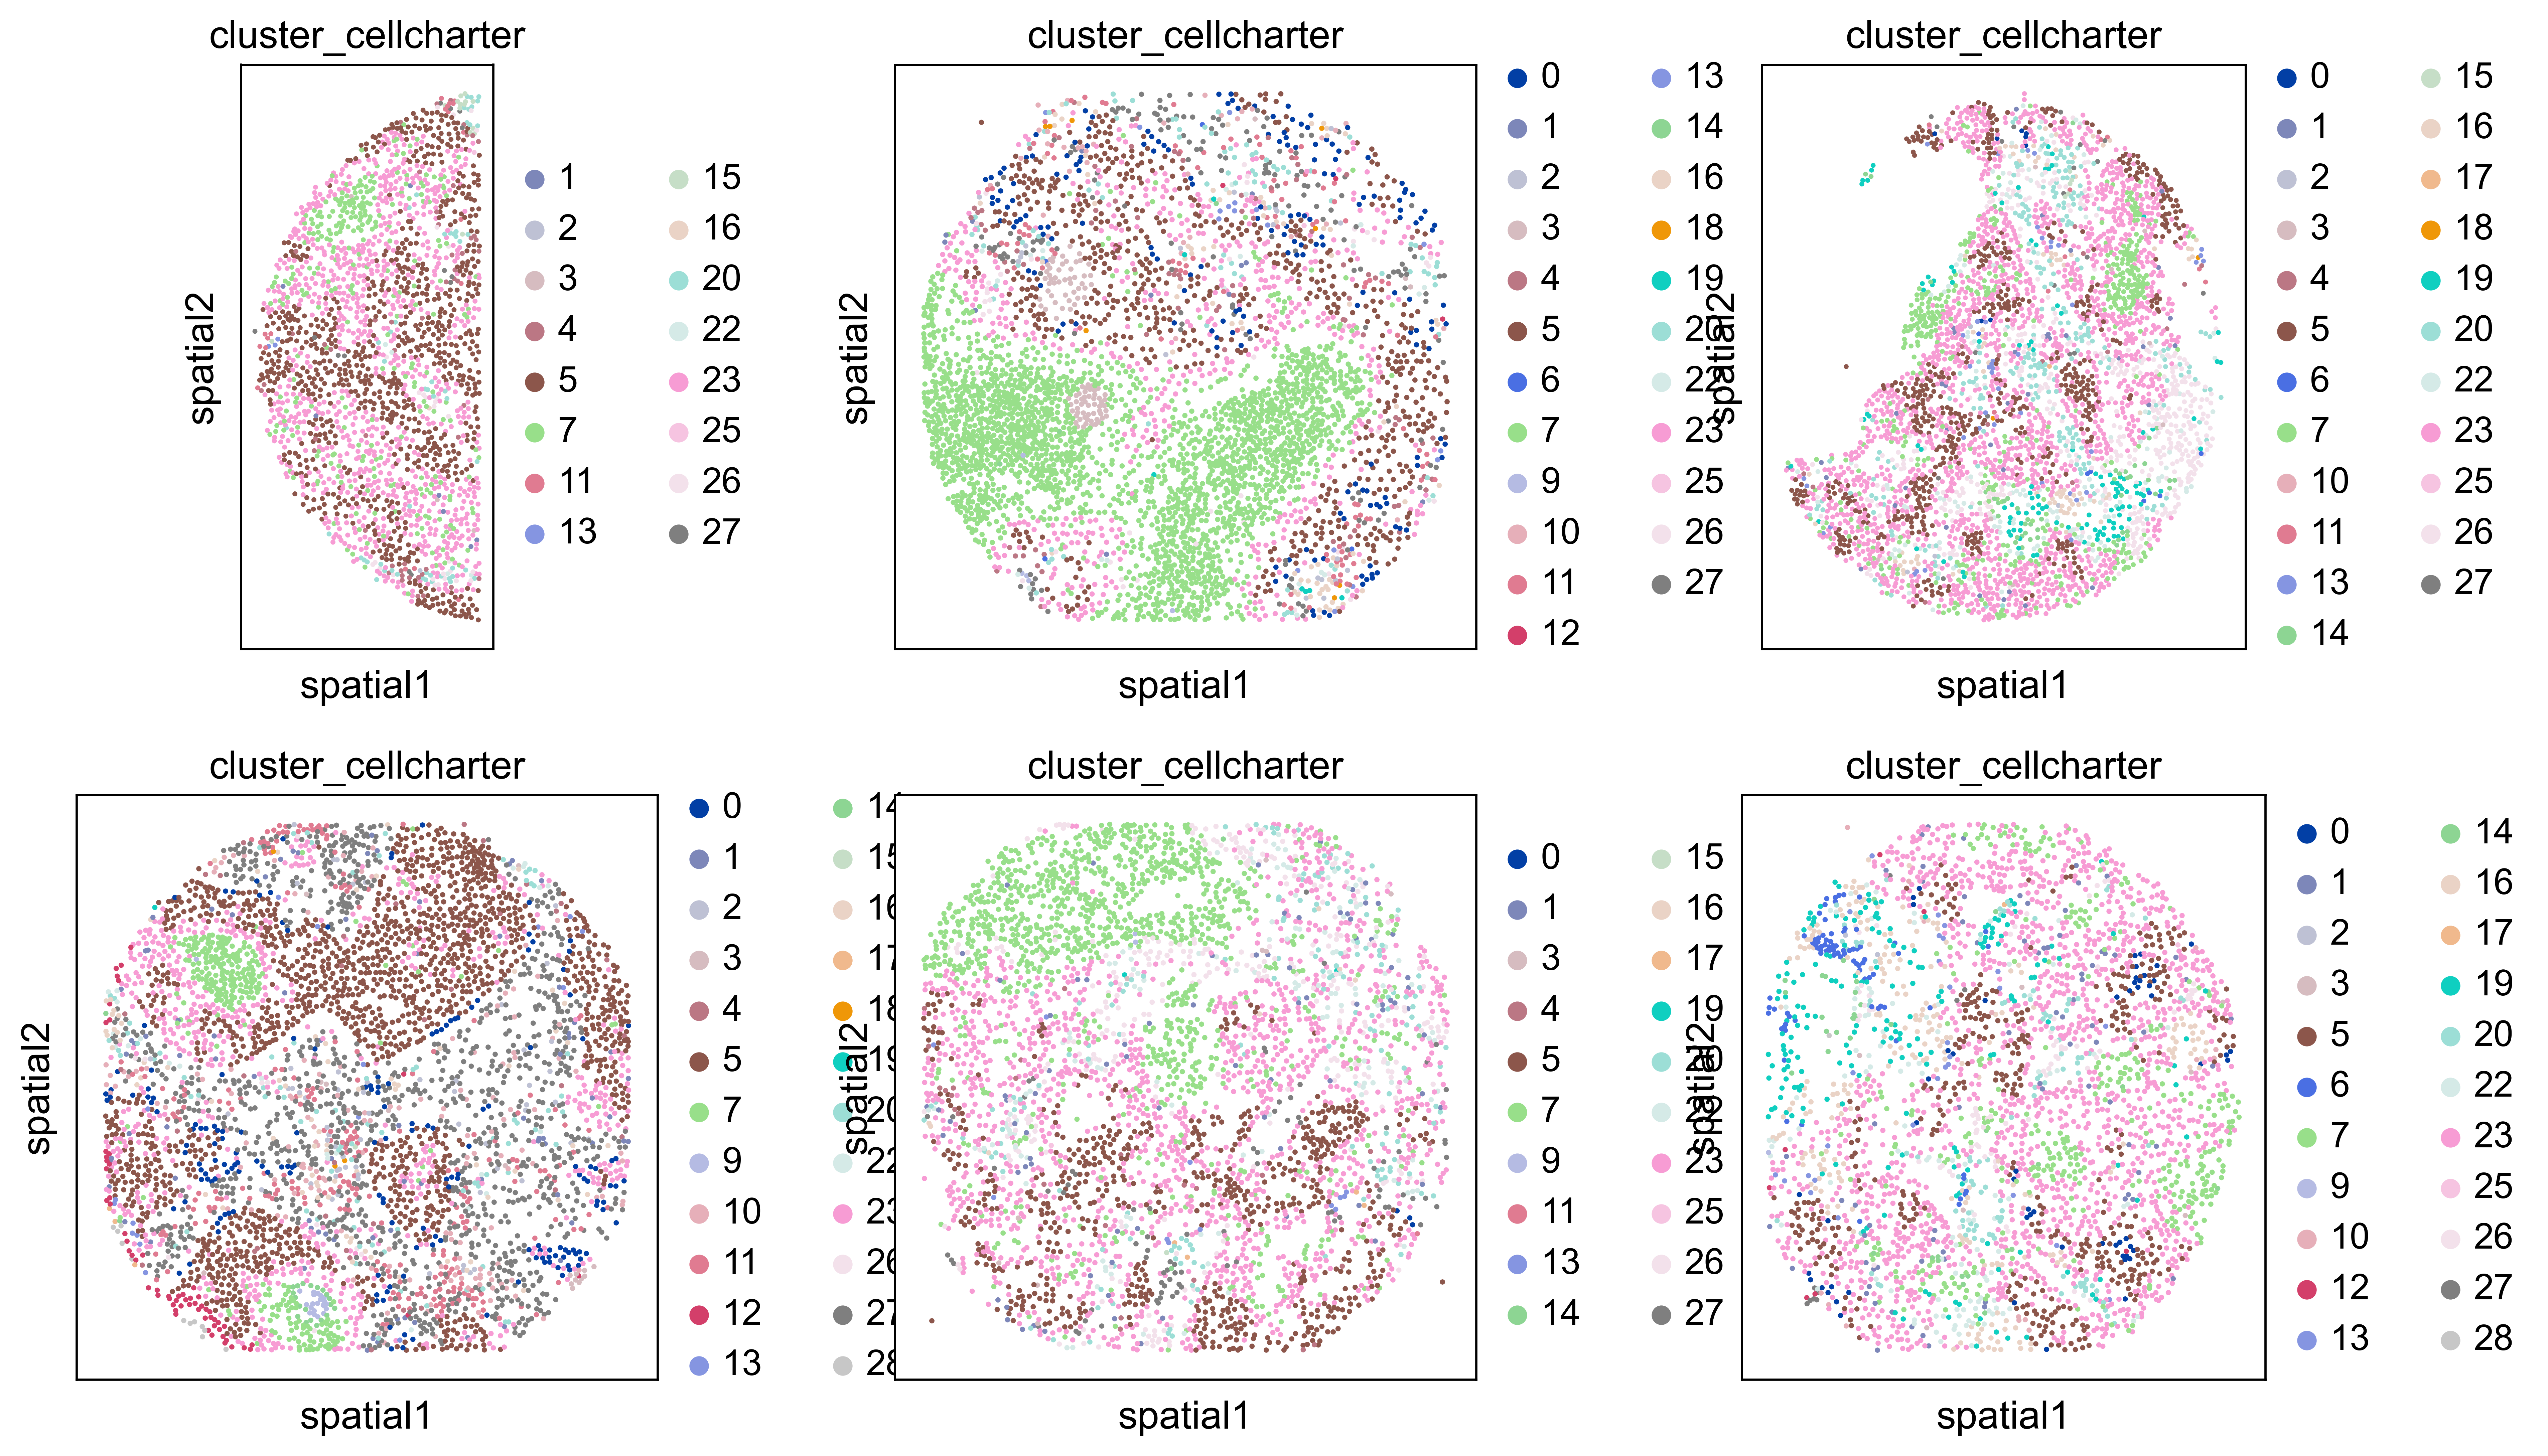

In [17]:
sq.pl.spatial_scatter(
    adata,
    color=['cluster_cellcharter'],
    library_key='FileName',
    size=5,
    img=None,
    ncols=3,
    library_id=sample_names,
)
